# Cuadros - Pintores

Basado en best-artworks.

Limpiado nombre y redimensionado a 224x224

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

2025-09-22 12:47:31.155520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758545251.186995 2978578 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758545251.196759 2978578 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758545251.220024 2978578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758545251.220046 2978578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758545251.220049 2978578 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [2]:
import os
import urllib.request
import tarfile

# M-todos-Generativos/Notebooks/1.2_05-Cuadros.ipynb
# https://drive.upm.es/s/MFijaLJA9EesFzq

# Download and unzip dataset from drive if not already done
if not os.path.exists("./data/imgs"):
    # Using urllib instead of gdown
    url = "https://drive.upm.es/s/MFijaLJA9EesFzq/download"
    output = "best-artworks.tar.gz"
    
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, output)
    
    # Create data directory if it doesn't exist
    os.makedirs("./data", exist_ok=True)
    
    # Extract zip file using zipfile module
    print("Extracting dataset...")
    with tarfile.open(output, 'r:gz') as tar_ref:
        tar_ref.extractall("./data")

    # Remove tar.gz file
    os.remove(output)
    print("Dataset ready!")



In [3]:
# Cargar datos de cuadros y extraer artistas del nombre del archivo
data_path = "./data/imgs"

# Obtener todas las imágenes
image_paths = glob(os.path.join(data_path, "*.jpg"))
print(f"Total de imágenes encontradas: {len(image_paths)}")

# Extraer artista del nombre del archivo
artists = []
image_files = []

for img_path in image_paths:
    filename = os.path.basename(img_path)
    # El artista es la parte antes del primer underscore
    artist = "_".join(filename.split('_')[0:-1])
    artists.append(artist)
    image_files.append(img_path)

# Crear DataFrame con la información
df = pd.DataFrame({
    'image_path': image_files,
    'artist': artists,
    'filename': [os.path.basename(path) for path in image_files]
})

# Codificar etiquetas de artistas
label_encoder = LabelEncoder()
df['artist_encoded'] = label_encoder.fit_transform(df['artist'])

df.head()

Total de imágenes encontradas: 8355


,image_path,artist,filename,artist_encoded
0,./data/imgs/Sandro_Botticelli_122.jpg,Sandro_Botticelli,Sandro_Botticelli_122.jpg,45
1,./data/imgs/Vincent_van_Gogh_412.jpg,Vincent_van_Gogh,Vincent_van_Gogh_412.jpg,48
2,./data/imgs/Pablo_Picasso_81.jpg,Pablo_Picasso,Pablo_Picasso_81.jpg,33
3,./data/imgs/Gustav_Klimt_89.jpg,Gustav_Klimt,Gustav_Klimt_89.jpg,19
4,./data/imgs/Jan_van_Eyck_39.jpg,Jan_van_Eyck,Jan_van_Eyck_39.jpg,26


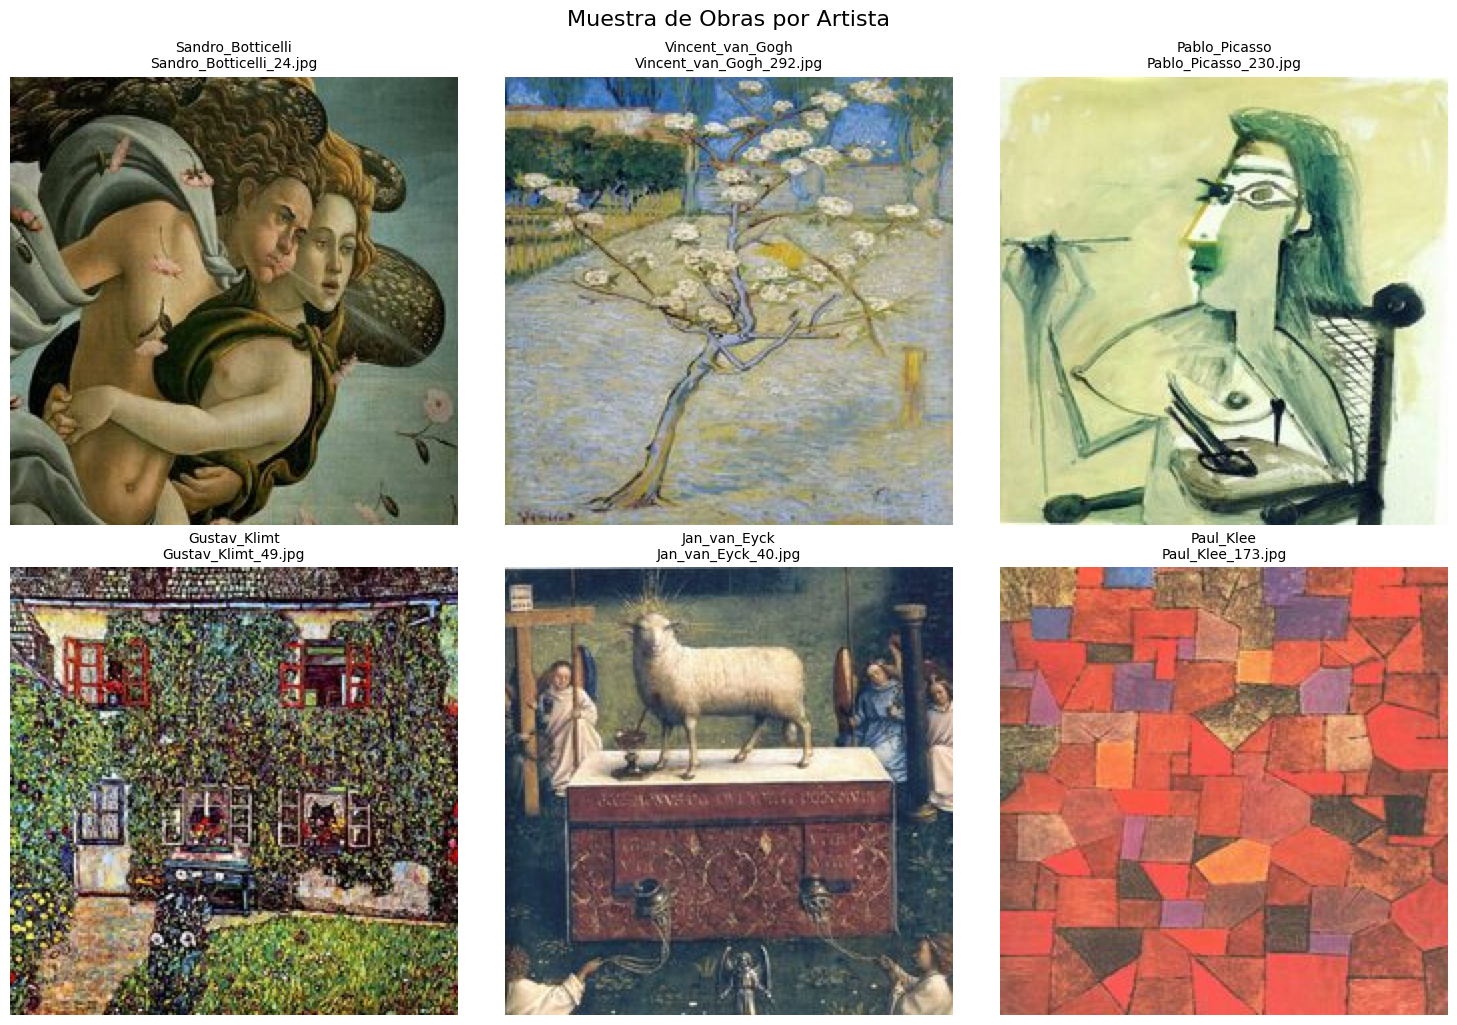

In [4]:
# Mostrar algunas obras de diferentes artistas
plt.figure(figsize=(15, 10))

# Seleccionar algunos artistas para mostrar
unique_artists = df['artist'].unique()[:6]  # Primeros 6 artistas
n_cols = 3
n_rows = 2

for i, artist in enumerate(unique_artists):
    # Obtener una obra aleatoria del artista
    artist_works = df[df['artist'] == artist]
    random_work = artist_works.sample(1).iloc[0]
    
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Cargar y mostrar la imagen
    img = load_img(random_work['image_path'], target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"{artist}\n{os.path.basename(random_work['filename'])}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Muestra de Obras por Artista", fontsize=16, y=1.02)
plt.show()

## Divisón train-test

Hay que tener en cuenta que no todas las clases tienen el mismo número de muestras. Habría que usar téncicas de selección o data augmentation para balancear la clases.

In [ ]:
# Dividir conjunto de datos en entrenamiento y test
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    df['image_path'], 
    df['artist_encoded'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['artist_encoded']
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de test: {len(X_test)}")
print(f"Número de clases: {len(np.unique(y_train))}")

# Convertir a categorical para Keras
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Shape de y_train_cat: {y_train_cat.shape}")
print(f"Shape de y_test_cat: {y_test_cat.shape}")

# Crear generadores de datos para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Configurar el tamaño de imagen y batch
img_size = 224
batch_size = 32

In [ ]:
# Función para crear el modelo CNN
def create_artist_classifier_model(num_classes, img_size=224):
    """
    Crear un modelo CNN para clasificación de artistas
    """
    
    return model

# Función alternativa usando transfer learning con VGG16
def create_transfer_learning_model(num_classes, img_size=224):
    """
    Crear un modelo usando transfer learning con VGG16
    """
    # Cargar VGG16 preentrenado sin las capas superiores
    base_model = VGG16(
        weights='imagenet',
        include_top=False, # No incluir la capa densa superior
        input_shape=(img_size, img_size, 3)
    )
        
    # Congelar las capas del modelo base
    base_model.trainable = False
    
    # Construcción con API funcional
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)   # Usar el modelo congelado
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    
    return model

print("Funciones de modelo definidas correctamente")

In [ ]:
# Instanciar y compilar el modelo
# Crear el modelo
model = create_transfer_learning_model(num_classes, img_size)

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
print("Resumen del modelo:")
model.summary()

# Mostrar información adicional
print(f"\nTotal de parámetros entrenables: {model.count_params():,}")
print(f"Número de clases: {num_classes}")
print(f"Tamaño de imagen: {img_size}x{img_size}")
print(f"Tamaño de batch: {batch_size}")

In [ ]:
import pickle

# Función para cargar y procesar imágenes
def load_and_preprocess_images(image_paths, labels, datagen, img_size, batch_size):
    """
    Generador de datos para cargar y procesar imágenes
    """
    # Convertir a arrays numpy si son pandas Series
    if hasattr(image_paths, 'values'):
        image_paths_array = image_paths.values
    else:
        image_paths_array = image_paths
        
    if hasattr(labels, 'values'):
        labels_array = labels.values
    else:
        labels_array = labels
    
    while True:
        # Shuffle de los datos
        indices = np.random.permutation(len(image_paths_array))
        
        for start_idx in range(0, len(image_paths_array), batch_size):
            end_idx = min(start_idx + batch_size, len(image_paths_array))
            batch_indices = indices[start_idx:end_idx]
            
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                # Cargar imagen
                img = load_img(image_paths_array[idx], target_size=(img_size, img_size))
                img_array = img_to_array(img)
                
                # Aplicar data augmentation
                img_array = datagen.flow(
                    np.expand_dims(img_array, axis=0), 
                    batch_size=1
                ).__next__()[0]
                
                batch_images.append(img_array)
                batch_labels.append(labels_array[idx])
            
            yield np.array(batch_images), np.array(batch_labels)

# Configurar callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_artist_classifier.checkpoint.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Entrenar el modelo
print("Iniciando entrenamiento...")

# Calcular pasos por época
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

# Entrenar
history = model.fit(
    load_and_preprocess_images(X_train, y_train_cat, train_datagen, img_size, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=load_and_preprocess_images(X_test, y_test_cat, test_datagen, img_size, batch_size),
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

model.save('trained.class.paintings.keras')

with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Entrenamiento completado!")

In [ ]:
# TODO

# Mostrar curvas de aprendizaje